<a href="https://colab.research.google.com/github/MLGlobalHealth/StatML4PopHealth/blob/updates_open_colab_buttons/lectures/day1/lecture4/Tutorial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/imperial.png" width="250" vspace="8"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/mlgh.png" width="220" hspace="50" vspace="5"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/ammi.png" width="190"/>

<font size="6">Modern Statistics and Machine Learning
for Population Health in Africa </font>

<font size="4">24th - 28th March 2025</font>

</center>

In [ ]:
!curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/scripts/utilities.py"

from utilities import custom_install_cmdstan, test_cmdstan_installation

custom_install_cmdstan()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2066  100  2066    0     0   2613      0 --:--:-- --:--:-- --:--:--  2611
Installing cmdstanpy==1.2.5
Unpacking colab-cmdstan-2.36.0.tar.gz
Installing required libtbb2 Linux package
Setting cmdstan path
CmdStan successfully installed!


In [ ]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
import arviz as az

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Aesthetics
sns.set_theme(style="whitegrid")
font = {"family": "sans-serif",
        "weight": "normal",
		"size": 10.5}
mpl.rc('font', **font)

## Objective
In the last tutorial, you were introduced to Bayesian linear models in Stan. In this tutorial, you will learn how to implement a polynomial regression in Stan. We will improve the model in the last tutorial by adding polynomial terms to account for the non-linear relationship between log GDP per capita and life expectancy.

In [ ]:
# Load the data and subset to 2007
df = pd.read_csv('https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/refs/heads/main/data/who_life_expectancy.csv')
df_2007 = df[df['Year'] == 2007].copy()
df_2007.loc[:, 'log_GDP_per_capita'] = np.log(df_2007['GDP_per_capita'])

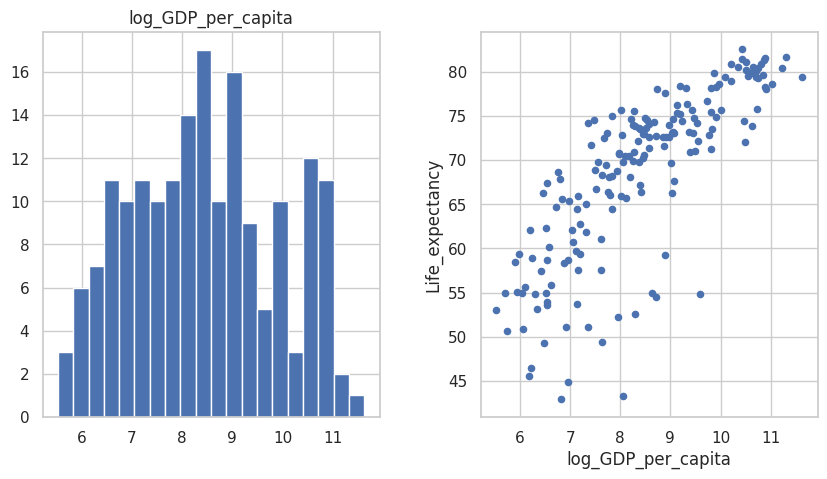

In [ ]:
# Plot the distribution of log GDP per capita and its relationship with life expectancy
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)
df_2007.hist(column='log_GDP_per_capita', bins=20, ax=ax[0])
df_2007.plot(x='log_GDP_per_capita', y='Life_expectancy', kind='scatter', ax=ax[1])
plt.show()

## Model Specification
Let $Y_i$ for $i=1,2,...,N$ denote the life expectancy and let $x_i$ denote the GDP per capita of country $i$. In the previous tutorial, we assumed that the relationship between the expected life expectancy and log GDP per capita is linear and built the following model:
$$
\begin{align*}
Y_i &\sim N(\mu(x_i), \sigma^2) \\
\mu(x_i) &= \beta_0 + \beta \log(x_i).
\end{align*}
$$
An analysis of the residuals suggested that the linear assumption and the homogeneous variance assumption may not be appropriate. Here, we will attempt to tackle the first issue by introducing polynomial terms to the model. Specifically, we will build a model of the following form:

For notational simplicity, let $u_i := \log(x_i)$. We wish to implement a model of the form
$$
\begin{align*}
Y_i &\sim N(\mu(u_i), \sigma^2) \\
\mu(u_i) &= \beta_0 + \sum_{p=1}^P \beta_p u_i^p.
\end{align*}
$$

## Implementation
Perhaps the most easy way to implement the linear predictor defined above is to choose a fixed value for $P$ and then hard code the polynomial terms in the `transformed parameters` or `models` block.
```stan
transformed parameters {
    vector[N] mu;
    mu = beta0 + beta1 * u + beta2 * u^2 + ... + betaP * u^P;
}
```
However, this approach forces us to rewrite the code every time we want to change the value of $P$. Alternatively we can pass $P$ as data to the model and use a loop to calculate the polynomial terms.

```stan
data {
    ...
    int<lower=0> P;
    ...
}
parameters {
    ...
    vector[P] beta;
    ...
}
transformed parameters {
    vector[N] mu;
    mu = beta0;
    for (p in 1:P) {
        mu += beta[p] * u^p;
    }
}
```

An even more elegant solution would be to use linear algebra. Given a vector of coefficients $\beta = (\beta_0, \beta_1, ..., \beta_P)^P$, and a design matrix $U \in \mathbb{R}^{N\times P}$ of the form
$$
U = \begin{bmatrix}
u_1 & u_1^2 & \cdots & u_1^P \\
u_2 & u_2^2 & \cdots & u_2^P \\
\vdots & \vdots & \ddots & \vdots \\
u_N & u_N^2 & \cdots & u_N^P
\end{bmatrix},
$$
We can write the vector $\mathbf{\mu}$ as $\mathbf{\mu} = U\beta$. This approach is more efficient than using a loop and is more flexible than hard coding the polynomial terms.

To construct the design matrix $U$, we can implement a helper function in the `functions` block. The `functions` block is placed at the very beginning of the Stan program and is used to define reusable functions. It can be very helpful when you want to keep your code clean and modular. You will see more of this in a later tutorial on Gaussian processes. Here, we want to define a function call `poly_basis` that takes a vector $u$ and an interger $P$ as input and returns the design matrix $U$. We can code this function as follows:
```stan
functions {
    matrix poly_basis(vector u, int P) {
        int N = num_elements(u);
        matrix[N, P] U;
        for (n in 1:N) {
            for (p in 1:P) {
                U[n, p] = pow(u[n], p);
            }
        }
        return U;
    }
}
```
We can then use this function to construct the design matrix $U$ in the `transformed data` block:
```stan
transformed data {
    vector[N] u = log(x);
    vector[N] u_std = (u_raw - mean(u_raw)) / sd(u_raw); // In practice, we should standardize the input
    matrix[N, P] U = poly_basis(u_std, P);
}
```
Finally, we can write the linear predictor as $\mu = U\beta$ in the `transformed parameters` block:
```stan
transformed parameters {
    vector[N] mu;
    mu = U * beta;
}
```
In summary, we have the following Stan program:
<details>
<summary>Click to expand Stan code</summary>

```stan
functions {
  // Polynomial basis function
  matrix poly_basis(vector x, int P) {
    int N = num_elements(x);
    matrix[N, P] U;
    for (n in 1:N) {
      for (p in 1:P) {
        U[n, p] = pow(x[n], p);
      }
    }
    return U;
  }
}
data {
  int<lower=1> N;
  int<lower=1> P;
  vector[N] x;
  array[N] real y;
}
transformed data {
  // Apply polynomial basis function to x
  vector[N] u = log(x);
  vector[N] u_std = (u - mean(u)) / sd(u);
  matrix[N, P] U = poly_basis(u_std, P);
}
parameters {
  real beta0;
  vector[P] beta;
  real<lower=0> inv_sigma;
}
transformed parameters {
  vector[N] mu;
  mu = beta0 + U*beta;
}
model {
  // Priors
  beta0 ~ normal(0, 10);
  beta ~ normal(0, 1);
  inv_sigma ~ exponential(5);

  // Likelihood
  y ~ normal(mu, 1/inv_sigma);
}
generated quantities {
  vector[N] log_lik;
  array[N] real y_rep;

  for (i in 1:N) {
    log_lik[i] = normal_lpdf(y[i] | mu[i], 1/inv_sigma);
    y_rep[i] = normal_rng(mu[i], 1/inv_sigma);
  }
}
```

</details>

In [ ]:
model = CmdStanModel(stan_file='polynomial_regression.stan')

17:37:45 - cmdstanpy - INFO - compiling stan file /content/polynomial_regression.stan to exe file /content/polynomial_regression
INFO:cmdstanpy:compiling stan file /content/polynomial_regression.stan to exe file /content/polynomial_regression
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=polynomial_regression.stan /content/polynomial_regression
cwd: cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Compiling pre-compiled header. This might take a few seconds. ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c stan/src/stan/model/model_header.hpp -o stan/src/stan

Let us fit a polynomial model of degree 3 to the data. We define the `stan_data` object accordingly.

In [ ]:
stan_data = {
    'N': df_2007.shape[0],
    'P': 3,
    'x': df_2007['GDP_per_capita'].values,
    'y': df_2007['Life_expectancy'].values
}

In [ ]:
fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000)

DEBUG:cmdstanpy:cmd: /content/polynomial_regression info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83j9tw4k/blb4qcsp.json
17:39:27 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=2', 'random', 'seed=69485', 'data', 'file=/tmp/tmp83j9tw4k/blb4qcsp.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regression6hxxflni/polynomial_regression-20250323173927_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=1', 'random', 'seed=69485', 'data', 'file=/tmp/tmp83j9tw4k/blb4qcsp.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regression6hxxflni/polynomial_regression-20250323173927_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=3', 'random', 'seed=69485',

17:39:30 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/polynomial_regression', 'id=1', 'random', 'seed=69485', 'data', 'file=/tmp/tmp83j9tw4k/blb4qcsp.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regression6hxxflni/polynomial_regression-20250323173927_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp83j9tw4k/polynomial_regression6hxxflni/polynomial_regression-20250323173927_1.csv
 console_msgs (if any):
	/tmp/tmp83j9tw4k/polynomial_regression6hxxflni/polynomial_regression-20250323173927_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    a

We go through the usual diagnostic workflow.

In [ ]:
# Check for sampling issues
print(fit.diagnose())

DEBUG:cmdstanpy:cmd: cmdstan-2.36.0/bin/diagnose /tmp/tmp83j9tw4k/polynomial_regression6hxxflni/polynomial_regression-20250323173927_1.csv /tmp/tmp83j9tw4k/polynomial_regression6hxxflni/polynomial_regression-20250323173927_2.csv /tmp/tmp83j9tw4k/polynomial_regression6hxxflni/polynomial_regression-20250323173927_3.csv /tmp/tmp83j9tw4k/polynomial_regression6hxxflni/polynomial_regression-20250323173927_4.csv
cwd: None


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [ ]:
# Convert the fit to an ArviZ InferenceData object
idata = az.from_cmdstanpy(fit)

In [ ]:
# Summarize the posterior and check for convergence (ess_bulk, ess_tail, r_hat)
az.summary(idata, var_names=['beta0', 'beta', 'inv_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,69.146,0.589,68.090,70.291,0.011,0.008,2903.0,2856.0,1.0
beta[0],4.047,0.711,2.679,5.329,0.015,0.012,2261.0,2460.0,1.0
beta[1],-0.835,0.397,-1.526,-0.060,0.008,0.007,2690.0,2693.0,1.0
beta[2],1.298,0.328,0.696,1.911,0.007,0.006,2282.0,2319.0,1.0
inv_sigma,0.167,0.009,0.149,0.183,0.000,0.000,3494.0,2822.0,1.0


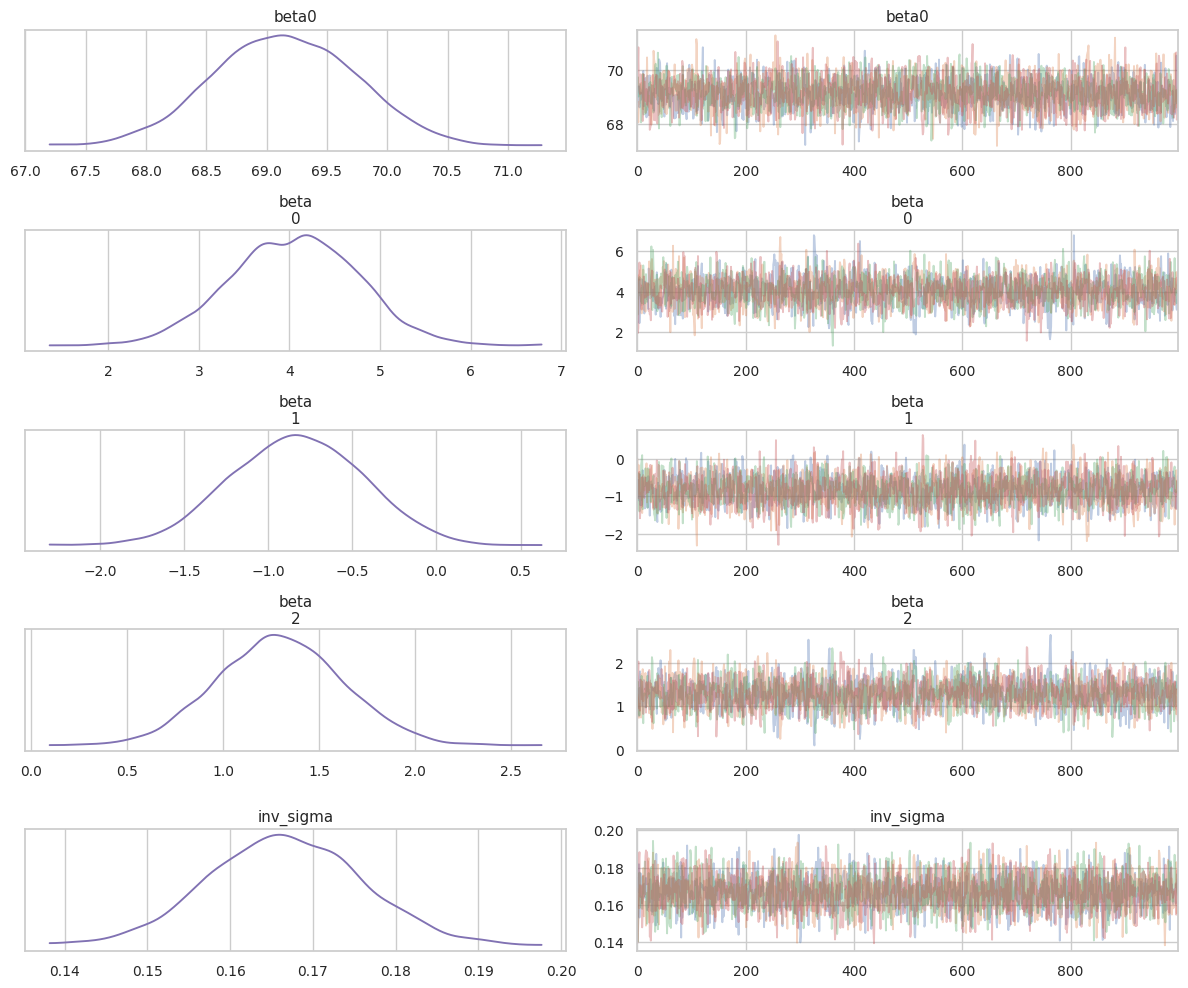

In [ ]:
# Visually inspect trace plots (convergence and mixing check)
az.plot_trace(idata, var_names=['beta0', 'beta', 'inv_sigma'], compact=False, combined=True)
plt.tight_layout()
plt.show()

We can now summarise the posterior distribution of the expected life expectancy given the GDP per capita.

In [ ]:
custom_stats = {
    "median": lambda x: np.percentile(x, 50),
	"ci_2.5%": lambda x: np.percentile(x, 2.5),
	"ci_97.5%": lambda x: np.percentile(x, 97.5)
}

In [ ]:
# Summarise the posterior of the mu parameter
mu_sum = az.summary(idata, var_names=['mu'], stat_funcs=custom_stats, extend=False)

# Append the data to the summary
mu_sum['GDP_per_capita'] = df_2007['GDP_per_capita'].values
mu_sum['log_GDP_per_capita'] = df_2007['log_GDP_per_capita'].values
mu_sum['Life_expectancy'] = df_2007['Life_expectancy'].values

# Sort the data by the log_GDP_per_capita
mu_sum = mu_sum.sort_values('log_GDP_per_capita')

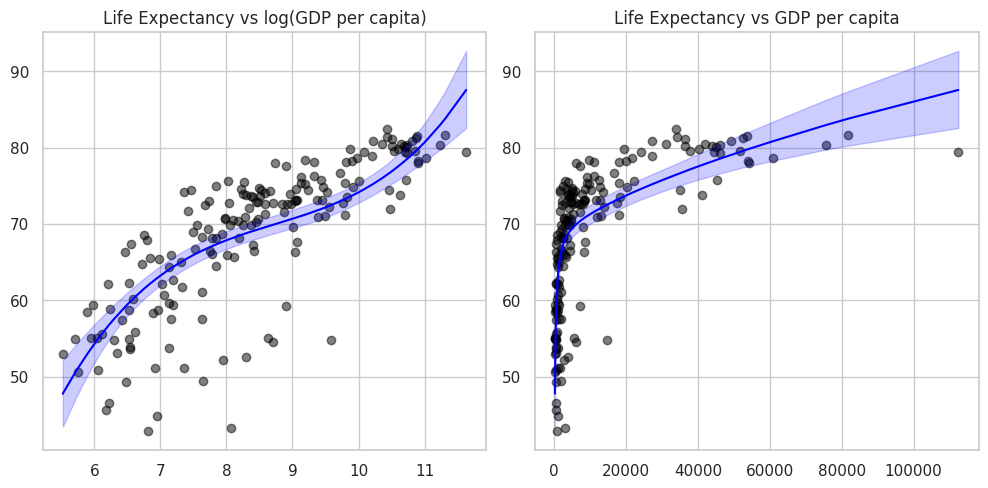

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)

# Plot the data
ax[0].scatter(mu_sum['log_GDP_per_capita'], mu_sum['Life_expectancy'], color='black', alpha=0.5)
ax[0].plot(mu_sum['log_GDP_per_capita'], mu_sum['median'], color='blue')
ax[0].fill_between(mu_sum['log_GDP_per_capita'], mu_sum['ci_2.5%'], mu_sum['ci_97.5%'], color='blue', alpha=0.2)
ax[0].set_title("Life Expectancy vs log(GDP per capita)")

ax[1].scatter(mu_sum['GDP_per_capita'], mu_sum['Life_expectancy'], color='black', alpha=0.5)
ax[1].plot(mu_sum['GDP_per_capita'], mu_sum['median'], color='blue')
ax[1].fill_between(mu_sum['GDP_per_capita'], mu_sum['ci_2.5%'], mu_sum['ci_97.5%'], color='blue', alpha=0.2)
ax[1].set_title("Life Expectancy vs GDP per capita")

plt.tight_layout()
plt.show()

We can also plot the posterior predictive distribution of the life expectancy given the GDP per capita.

In [ ]:
y_rep_sum = az.summary(idata, var_names=['y_rep'], stat_funcs=custom_stats, extend=False)

In [ ]:
y_rep_sum['y'] = df_2007['Life_expectancy'].values
y_rep_sum['within_95_ci'] = np.where((y_rep_sum['ci_2.5%'] < y_rep_sum['y']) & (y_rep_sum['ci_97.5%'] > y_rep_sum['y']), 1, 0)
print('Proportion of points within 95% CI {}'.format(y_rep_sum['within_95_ci'].mean()))

Proportion of points within 95% CI 0.9385474860335196


In [ ]:
y_rep_sum['GDP_per_capita'] = df_2007['GDP_per_capita'].values
y_rep_sum['log_GDP_per_capita'] = df_2007['log_GDP_per_capita'].values
y_rep_sum['Country'] = df_2007['Country'].values
y_rep_sum = y_rep_sum.sort_values('log_GDP_per_capita')

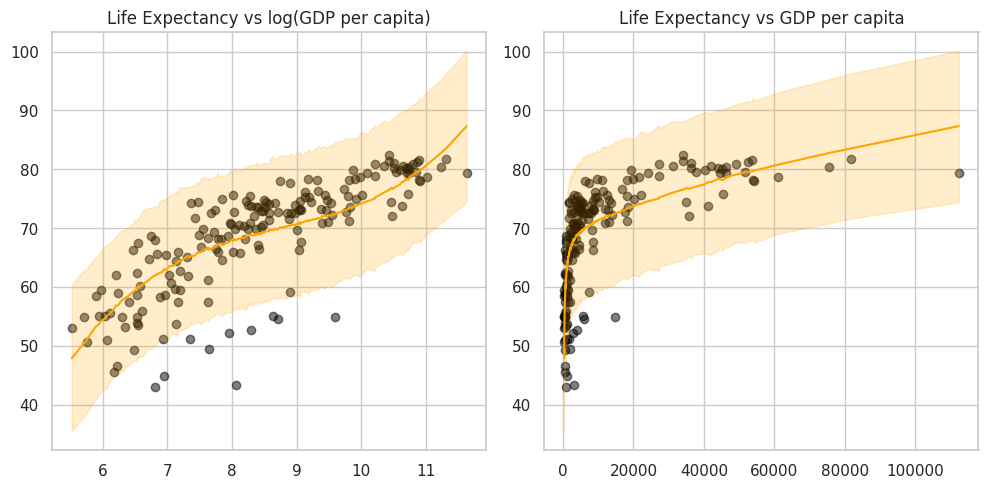

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)

ax[0].scatter(y_rep_sum['log_GDP_per_capita'], y_rep_sum['y'], color='black', alpha=0.5)
ax[0].plot(y_rep_sum['log_GDP_per_capita'], y_rep_sum['median'], color='orange')
ax[0].fill_between(y_rep_sum['log_GDP_per_capita'], y_rep_sum['ci_2.5%'], y_rep_sum['ci_97.5%'], color='orange', alpha=0.2)
ax[0].set_title("Life Expectancy vs log(GDP per capita)")

ax[1].scatter(y_rep_sum['GDP_per_capita'], y_rep_sum['y'], color='black', alpha=0.5)
ax[1].plot(y_rep_sum['GDP_per_capita'], y_rep_sum['median'], color='orange')
ax[1].fill_between(y_rep_sum['GDP_per_capita'], y_rep_sum['ci_2.5%'], y_rep_sum['ci_97.5%'], color='orange', alpha=0.2)
ax[1].set_title("Life Expectancy vs GDP per capita")

plt.tight_layout()
plt.show()

Is this model better than the linear model? How should be determine the best polynomial degree?

## Model Comparison using LOO and WAIC

One way to compare models quantitatively is to use information criteria such as the Leave-One-Out Cross Validation (LOO) and the Widely Applicable Information Criterion (WAIC). These criteria are based on the out-of-sample predictive accuracy of the model. The lower the value of the criterion, the better the model.

We first fit different polynomial models to the data and compute the LOO and WAIC values for each model. We can then compare the models based on these values.

In [ ]:
stan_data['P'] = 1
mod_linear = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000)

DEBUG:cmdstanpy:cmd: /content/polynomial_regression info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83j9tw4k/ozegzwpr.json
17:39:45 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=1', 'random', 'seed=41227', 'data', 'file=/tmp/tmp83j9tw4k/ozegzwpr.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressionmrdyaz4z/polynomial_regression-20250323173945_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=2', 'random', 'seed=41227', 'data', 'file=/tmp/tmp83j9tw4k/ozegzwpr.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressionmrdyaz4z/polynomial_regression-20250323173945_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=3', 'random', 'seed=41227',

17:39:47 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/polynomial_regression', 'id=1', 'random', 'seed=41227', 'data', 'file=/tmp/tmp83j9tw4k/ozegzwpr.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressionmrdyaz4z/polynomial_regression-20250323173945_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp83j9tw4k/polynomial_regressionmrdyaz4z/polynomial_regression-20250323173945_1.csv
 console_msgs (if any):
	/tmp/tmp83j9tw4k/polynomial_regressionmrdyaz4z/polynomial_regression-20250323173945_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    a

In [ ]:
stan_data['P'] = 2
mod_poly2 = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000)

DEBUG:cmdstanpy:cmd: /content/polynomial_regression info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83j9tw4k/54kgzs6j.json
17:39:47 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=1', 'random', 'seed=8939', 'data', 'file=/tmp/tmp83j9tw4k/54kgzs6j.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressionmuosixmp/polynomial_regression-20250323173947_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=2', 'random', 'seed=8939', 'data', 'file=/tmp/tmp83j9tw4k/54kgzs6j.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressionmuosixmp/polynomial_regression-20250323173947_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=3', 'random', 'seed=8939', 'd

17:39:49 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/polynomial_regression', 'id=1', 'random', 'seed=8939', 'data', 'file=/tmp/tmp83j9tw4k/54kgzs6j.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressionmuosixmp/polynomial_regression-20250323173947_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp83j9tw4k/polynomial_regressionmuosixmp/polynomial_regression-20250323173947_1.csv
 console_msgs (if any):
	/tmp/tmp83j9tw4k/polynomial_regressionmuosixmp/polynomial_regression-20250323173947_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    ad

In [ ]:
stan_data['P'] = 3
mod_poly3 = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000)

DEBUG:cmdstanpy:cmd: /content/polynomial_regression info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83j9tw4k/7x_6xb1n.json
17:39:50 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=1', 'random', 'seed=16494', 'data', 'file=/tmp/tmp83j9tw4k/7x_6xb1n.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressionacpwchud/polynomial_regression-20250323173950_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=2', 'random', 'seed=16494', 'data', 'file=/tmp/tmp83j9tw4k/7x_6xb1n.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressionacpwchud/polynomial_regression-20250323173950_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=3', 'random', 'seed=16494',

17:39:52 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/polynomial_regression', 'id=1', 'random', 'seed=16494', 'data', 'file=/tmp/tmp83j9tw4k/7x_6xb1n.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressionacpwchud/polynomial_regression-20250323173950_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp83j9tw4k/polynomial_regressionacpwchud/polynomial_regression-20250323173950_1.csv
 console_msgs (if any):
	/tmp/tmp83j9tw4k/polynomial_regressionacpwchud/polynomial_regression-20250323173950_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    a

In [ ]:
stan_data['P'] = 4
mod_poly4 = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000)

DEBUG:cmdstanpy:cmd: /content/polynomial_regression info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83j9tw4k/pla7u7v4.json
17:39:52 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=1', 'random', 'seed=37194', 'data', 'file=/tmp/tmp83j9tw4k/pla7u7v4.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressiono33stgh6/polynomial_regression-20250323173952_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=2', 'random', 'seed=37194', 'data', 'file=/tmp/tmp83j9tw4k/pla7u7v4.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressiono33stgh6/polynomial_regression-20250323173952_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=4', '

17:39:55 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/polynomial_regression', 'id=1', 'random', 'seed=37194', 'data', 'file=/tmp/tmp83j9tw4k/pla7u7v4.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressiono33stgh6/polynomial_regression-20250323173952_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp83j9tw4k/polynomial_regressiono33stgh6/polynomial_regression-20250323173952_1.csv
 console_msgs (if any):
	/tmp/tmp83j9tw4k/polynomial_regressiono33stgh6/polynomial_regression-20250323173952_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    a

In [ ]:
stan_data['P'] = 5
mod_poly5 = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000)

DEBUG:cmdstanpy:cmd: /content/polynomial_regression info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83j9tw4k/gnxmszg7.json
17:39:56 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=1', 'random', 'seed=31847', 'data', 'file=/tmp/tmp83j9tw4k/gnxmszg7.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressionh43g06gh/polynomial_regression-20250323173956_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=2', 'random', 'seed=31847', 'data', 'file=/tmp/tmp83j9tw4k/gnxmszg7.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressionh43g06gh/polynomial_regression-20250323173956_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/polynomial_regression', 'id=3', 'random', 'seed=31847',

17:40:01 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/polynomial_regression', 'id=1', 'random', 'seed=31847', 'data', 'file=/tmp/tmp83j9tw4k/gnxmszg7.json', 'output', 'file=/tmp/tmp83j9tw4k/polynomial_regressionh43g06gh/polynomial_regression-20250323173956_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp83j9tw4k/polynomial_regressionh43g06gh/polynomial_regression-20250323173956_1.csv
 console_msgs (if any):
	/tmp/tmp83j9tw4k/polynomial_regressionh43g06gh/polynomial_regression-20250323173956_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    a

We define a helper function to extract the posterior distribution of `mu`.

In [ ]:
def get_mu_summary(mod):
    idata = az.from_cmdstanpy(mod)
    mu_sum = az.summary(idata, var_names=['mu'], stat_funcs=custom_stats, extend=False)
    mu_sum['GDP_per_capita'] = df_2007['GDP_per_capita'].values
    mu_sum['log_GDP_per_capita'] = df_2007['log_GDP_per_capita'].values
    mu_sum['Life_expectancy'] = df_2007['Life_expectancy'].values
    mu_sum = mu_sum.sort_values('log_GDP_per_capita')

    return mu_sum

In [ ]:
# Get the mu summaries for each model
models = [mod_linear, mod_poly2, mod_poly3, mod_poly4, mod_poly5]
mu_summaries = [get_mu_summary(mod) for mod in models]

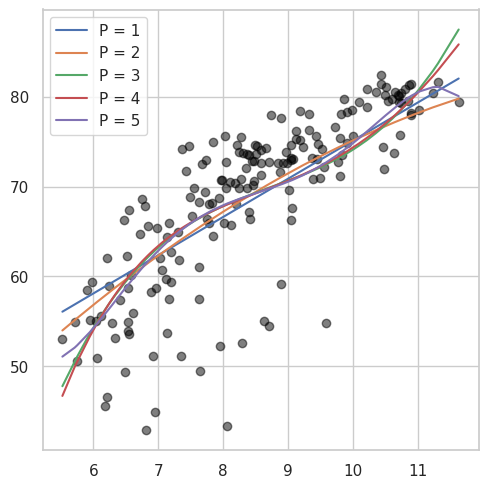

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

for i, mu_sum in enumerate(mu_summaries):
    ax.plot(mu_sum['log_GDP_per_capita'], mu_sum['median'], label='P = {}'.format(i+1))

ax.scatter(mu_sum['log_GDP_per_capita'], mu_sum['Life_expectancy'], color='black', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
def extract_elpd_loo(model):
    idata = az.from_cmdstanpy(model)
    loo = az.loo(idata, pointwise=True)
    waic = az.waic(idata, pointwise=True)

    df = pd.DataFrame({'elpd_loo': loo['elpd_loo'], 'elpd_waic': waic['elpd_waic']}, index=[0])
    return df

In [ ]:
dfs = []
for i, mod in enumerate(models):
    df = extract_elpd_loo(mod)
    df['P'] = i + 1
    dfs.append(df)
df_model_comparison = pd.concat(dfs)

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the

In [ ]:
df_model_comparison.sort_values('elpd_loo', ascending=True)

,elpd_loo,elpd_waic,P
0,-578.576186,-578.488830,4
0,-577.893535,-577.848866,3
0,-576.161847,-576.150703,1
0,-574.588057,-574.537871,5
0,-574.459916,-574.428043,2


Although the difference in the LOO and WAIC values is small across the models, it seems that the model with degree 4 polynomial terms has the lowest value. Hence we can conclude that the model with degree 4 polynomial terms is the best model among the ones we have considered.